In [1]:
import sys
sys.path.append('../src')  # add source directory to path for imports

from pathlib import Path
from operator import itemgetter
from tqdm import tqdm

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from utils import class2one_hot
from dataset import SliceDataset

In [2]:
root_dir = "../" / Path("data") / "SEGTHOR"

K = 5  # Number of classes

img_transform = transforms.Compose(
    [
        lambda img: img.convert("L"),  # convert to grayscale
        lambda img: np.array(img)[np.newaxis, ...],
        lambda nd: nd / 255,  # max <= 1 (range [0, 1])
        lambda nd: torch.tensor(nd, dtype=torch.float32),
    ]
)

gt_transform = transforms.Compose(
    [
        lambda img: np.array(img)[...],
        # The idea is that the classes are mapped to {0, 255} for binary cases
        # {0, 85, 170, 255} for 4 classes
        # {0, 51, 102, 153, 204, 255} for 6 classes
        # Very sketchy but that works here and that simplifies visualization
        lambda nd: nd / (255 / (K - 1)) if K != 5 else nd / 63,  # max <= 1
        lambda nd: torch.tensor(nd, dtype=torch.int64)[
            None, ...
        ],  # Add one dimension to simulate batch
        lambda t: class2one_hot(t, K=K),
        itemgetter(0),
    ]
)

train_set = SliceDataset(
    "train",
    root_dir,
    img_transform=img_transform,
    gt_transform=gt_transform,
    debug=False,
)
train_loader = DataLoader(
    train_set, batch_size=1, num_workers=4, shuffle=False
)

val_set = SliceDataset(
    "val",
    root_dir,
    img_transform=img_transform,
    gt_transform=gt_transform,
    debug=False,
)
val_loader = DataLoader(
    val_set, batch_size=1, num_workers=4, shuffle=False
)

>> Created train dataset with 5453 images...
>> Created val dataset with 1967 images...


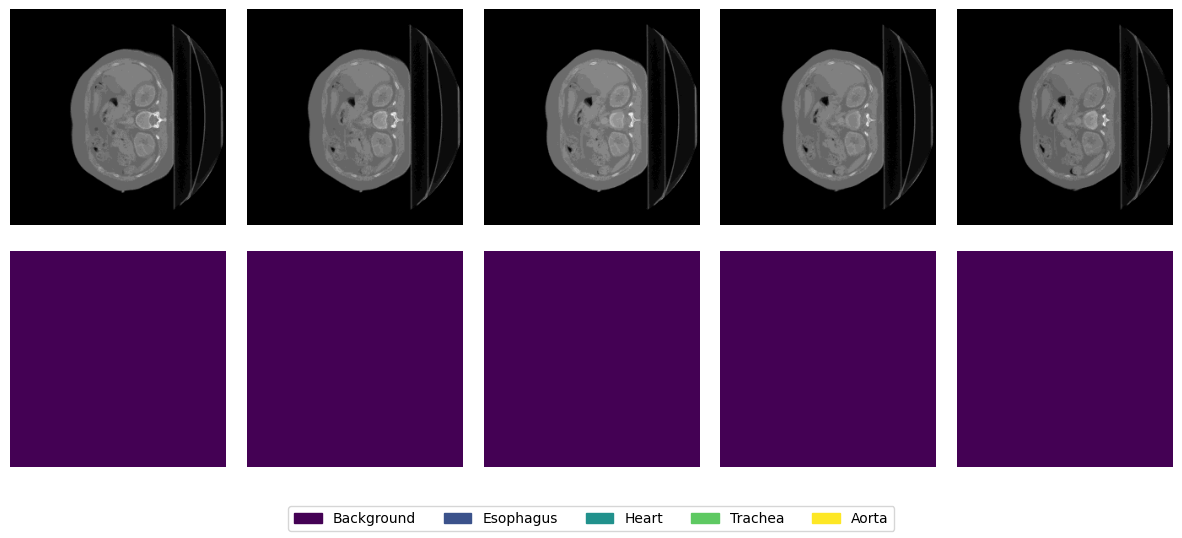

In [74]:
# Let's check some samples

num_samples = 5

fig, ax = plt.subplots(2, num_samples, figsize=(15, 6))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, batch in enumerate(train_loader):
    if i == num_samples:
        break

    img = batch["images"]
    gt = batch["gts"]

    color_map = plt.get_cmap("viridis", K)
    gt_colored = color_map(gt[0].argmax(dim=0).cpu().numpy())

    ax[0, i].imshow(img[0, 0], cmap="gray")
    ax[1, i].imshow(gt_colored)

    ax[0, i].axis('off')
    ax[1, i].axis('off')

legend_elements = [
    plt.Rectangle((0, 0), 1, 1, color=color_map(i)) for i in range(K)
]
fig.legend(
    legend_elements, 
    ["Background", "Esophagus", "Heart", "Trachea", "Aorta"], 
    loc="lower center", 
    ncol=K
)
plt.show()

In [53]:
# count the number of ground truth images that are completely background

def print_stats(data_loader):
    n_background = total = 0
    n_esophagus = n_heart = n_trachea = n_aorta = 0

    for i, batch in tqdm(enumerate(data_loader)):
        gt = batch["gts"]

        mask = gt[0].argmax(dim=0)
        if mask.sum() == 0:
            n_background += 1
            total += 1
            continue

        if mask.eq(1).sum() > 0:
            n_esophagus += 1
        if mask.eq(2).sum() > 0:
            n_heart += 1
        if mask.eq(3).sum() > 0:
            n_trachea += 1
        if mask.eq(4).sum() > 0:
            n_aorta += 1
        total += 1

    print(f"\nTotal number of ground truth images: {total}\n")
    print(f"Number of ground truth images that are completely background: {n_background}")
    print(f"Percentage: {n_background / total * 100:.2f}%\n")
    print(f"Number of esophagus images: {n_esophagus}")
    print(f"Percentage: {n_esophagus / total * 100:.2f}%\n")
    print(f"Number of heart images: {n_heart}")
    print(f"Percentage: {n_heart / total * 100:.2f}%\n")
    print(f"Number of trachea images: {n_trachea}")
    print(f"Percentage: {n_trachea / total * 100:.2f}%\n")
    print(f"Number of aorta images: {n_aorta}")
    print(f"Percentage: {n_aorta / total * 100:.2f}%\n")

In [54]:
print("Training set:\n")
print_stats(train_loader)

print("-" * 40)

print("Validation set:\n")
print_stats(val_loader)

Training set:



5453it [00:57, 95.64it/s] 


Total number of ground truth images: 5453

Number of ground truth images that are completely background: 1948
Percentage: 35.72%

Number of esophagus images: 2942
Percentage: 53.95%

Number of heart images: 1203
Percentage: 22.06%

Number of trachea images: 1495
Percentage: 27.42%

Number of aorta images: 2797
Percentage: 51.29%

----------------------------------------
Validation set:




1967it [00:20, 95.61it/s] 


Total number of ground truth images: 1967

Number of ground truth images that are completely background: 786
Percentage: 39.96%

Number of esophagus images: 978
Percentage: 49.72%

Number of heart images: 396
Percentage: 20.13%

Number of trachea images: 492
Percentage: 25.01%

Number of aorta images: 957
Percentage: 48.65%



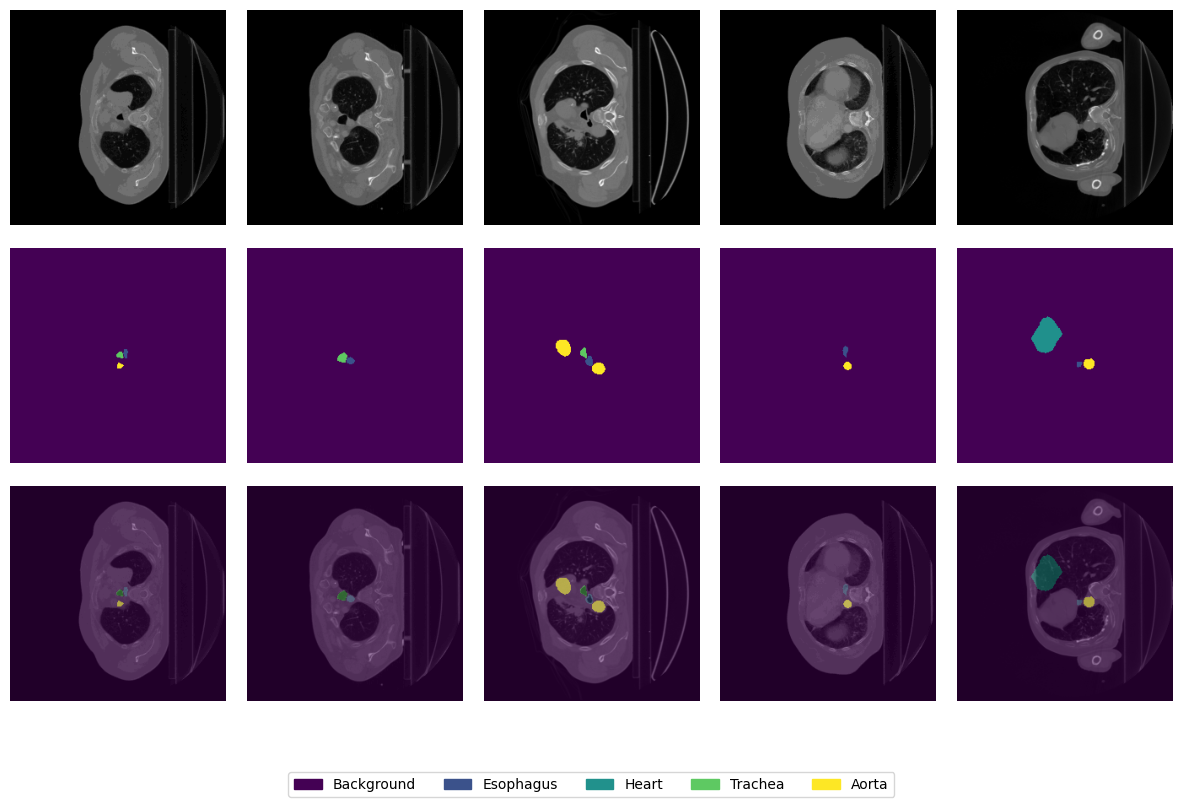

In [69]:
# Let's check some non-background samples

train_loader = DataLoader(
    train_set, batch_size=1, num_workers=4, shuffle=True
)

num_samples = 5

fig, ax = plt.subplots(3, num_samples, figsize=(15, 9))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

current_sample = 0

for i, batch in enumerate(train_loader):
    if current_sample == num_samples:
        break

    img = batch["images"]
    gt = batch["gts"]

    if gt[0].argmax(dim=0).sum() == 0:
        continue

    color_map = plt.get_cmap("viridis", K)
    gt_colored = color_map(gt[0].argmax(dim=0).cpu().numpy())

    ax[0, current_sample].imshow(img[0, 0], cmap="gray")
    ax[1, current_sample].imshow(gt_colored)

    ax[0, current_sample].axis('off')
    ax[1, current_sample].axis('off')

    # Overlay the colored ground truth on the original image
    ax[2, current_sample].imshow(img[0, 0], cmap="gray")
    ax[2, current_sample].imshow(gt_colored, alpha=0.5)

    ax[0, current_sample].axis('off')
    ax[1, current_sample].axis('off')
    ax[2, current_sample].axis('off')

    current_sample += 1

legend_elements = [
    plt.Rectangle((0, 0), 1, 1, color=color_map(i)) for i in range(K)
]
fig.legend(
    legend_elements, 
    ["Background", "Esophagus", "Heart", "Trachea", "Aorta"], 
    loc="lower center", 
    ncol=K
)
plt.show()

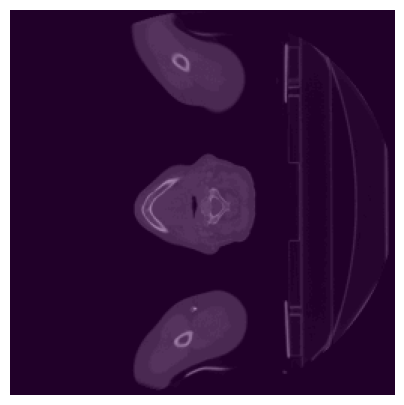

In [6]:
import matplotlib.animation as animation

train_loader = DataLoader(
    train_set, batch_size=1, num_workers=4, shuffle=False
)

num_samples = int(len(train_loader)*0.025)
imgs = []
gts = []

for i, batch in enumerate(train_loader):
    if i == num_samples:
        break

    img = batch["images"]
    gt = batch["gts"]

    imgs.append(img)
    gts.append(gt)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

def update_frame(i):
    ax.clear()
    img = imgs[i]
    gt = gts[i]

    color_map = plt.get_cmap("viridis", K)
    gt_colored = color_map(gt[0].argmax(dim=0).cpu().numpy())

    # Overlay the colored ground truth on the original image without background
    ax.imshow(img[0, 0], cmap="gray")
    ax.imshow(gt_colored, alpha=0.5)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update_frame, frames=num_samples, repeat=False)

# Save the animation as a video file
ani.save('overlapping_images.mp4', writer='ffmpeg', fps=2)

plt.show()